In [45]:
import numpy as np 
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

import time
from sklearn.covariance import empirical_covariance

from regain.covariance.graphical_lasso_ import GraphicalLasso
from regain.datasets.datasets import make_dataset
from regain.scores import log_likelihood, BIC, EBIC, EBIC_m
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from regain.utils import structure_error, error_norm
from sklearn.metrics import matthews_corrcoef
from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection

## Generation of the datasets changing proportion of samples and dimensions

In [2]:
Xs = []
thetas = []

combos = [(1000, 10), (100,10), (100, 100), (10, 100)]
for c in combos:
    res = make_dataset(n_samples=c[0], n_dim_obs=c[1], n_dim_lat=0, T=1)
    Xs.append(res['data'][0])
    thetas.append(res['thetas'][0])

In [52]:
Xs = Xs[:2]
thetas = thetas[:2]

In [54]:
res = make_dataset(n_samples=20, n_dim_obs=100, n_dim_lat=0, T=1)
Xs.append(res['data'][0])
thetas.append(res['thetas'][0])

# Test the hyperparameter selection with likelihood, BIC, EBIC, EBIC_m and stability with no noise


In [3]:
def score(estimator, X_test, score_type='likelihood'):
        test_cov = empirical_covariance(X_test, assume_centered=False)
        
        if score_type.lower() == 'likelihood':
            return log_likelihood(test_cov, estimator.precision_)
        elif score_type.lower() == 'bic':
            return BIC(test_cov, estimator.precision_)
        elif score_type.lower() == 'ebic':
            return EBIC(test_cov, estimator.precision_)
        elif score_type.lower() == 'ebic_m':
            return EBIC_m(test_cov, estimator.precision_)
        else:
            raise ValueError('Undefined type of scores, accepted scores are [likelihood, bic, ebic or ebic_m]')

### 1000 samples, 10 variables

In [57]:
def test_all(X, theta):
    train_MCC = {k:[] for k in ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']}
    test_MCC = {k:[] for k in ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']}
    train_scores  = {k:[] for k in ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']}
    test_scores = {k:[] for k in ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']}
    selected_parameters = {k:[] for k in ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']}
    train_error_norm = {k:[] for k in ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']}
    test_error_norm = {k:[] for k in ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']}
    
    times = {k:[] for k in ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']}



    est = GraphicalLasso()


    sss = ShuffleSplit(n_splits=100, test_size=0.5)
    for train, test in sss.split(X):

        for t in ['likelihood', 'bic', 'ebic', 'ebic_m']:
            scoref = partial(score, score_type=t)
            tim = time.clock()
            rscv = RandomizedSearchCV(est, param_distributions={'alpha':np.logspace(-3, -1, 100)},
                                      cv=5, scoring=scoref)
            rscv.fit(X[train,:])
            times[t].append(time.clock() - tim)
            
            selected_parameters[t].append(rscv.best_estimator_.alpha)
            train_MCC[t].append(matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0))
            train_error_norm[t].append(error_norm(theta, rscv.best_estimator_.precision_))
            train_scores[t].append(scoref(rscv.best_estimator_, X[train, :]))
            rscv.best_estimator_.fit(X[test,:])
            test_MCC[t].append((matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0)))
            test_error_norm[t].append(error_norm(theta, rscv.best_estimator_.precision_))
            test_scores[t].append(scoref(rscv.best_estimator_, X[test, :]))
        sampling_size = min(int(10*np.sqrt(train.shape[0])),  train.shape[0]-int(train.shape[0]*0.25))
        tim = time.clock()
        ss = GraphicalModelStabilitySelection(est, n_repetitions=10, sampling_size=sampling_size, 
                                              params_grid={'alpha':np.linspace(1e-5, 1e3, 100)})
        ss.fit(X[train, :])
        times['stars'].append(time.clock() - tim)
        selected_parameters['stars'].append(ss.best_estimator_.alpha)
        train_MCC['stars'].append(matthews_corrcoef(theta.ravel()!=0, ss.best_estimator_.precision_.ravel()!=0))
        train_error_norm['stars'].append(error_norm(theta, ss.best_estimator_.precision_))
        train_scores['stars'].append(scoref(ss.best_estimator_, X[train, :]))
        ss.best_estimator_.fit(X[test,:])
        test_MCC['stars'].append((matthews_corrcoef(theta.ravel()!=0, ss.best_estimator_.precision_.ravel()!=0)))
        test_error_norm['stars'].append(error_norm(theta, ss.best_estimator_.precision_))
        test_scores['stars'].append(scoref(ss.best_estimator_, X[test, :]))
        
    result = [pd.DataFrame.from_dict(train_MCC), 
              pd.DataFrame.from_dict(test_MCC),
              pd.DataFrame.from_dict(train_scores),
              pd.DataFrame.from_dict(test_scores),
              pd.DataFrame.from_dict(train_error_norm),
              pd.DataFrame.from_dict(test_error_norm), 
              pd.DataFrame.from_dict(selected_parameters),
              pd.DataFrame.from_dict(times)]
    return result
            

In [48]:
import warnings
warnings.simplefilter("ignore")

X = Xs[0]
theta = thetas[0]
res_1000_10 = test_all(X, theta)

In [49]:
X = Xs[1]
theta = thetas[1]
res_100_10 = test_all(X, theta)

In [50]:
X = Xs[2]
theta = thetas[2]
res_100_100 = test_all(X, theta)

In [58]:
X = Xs[2]
theta = thetas[2]
res_20_100 = test_all(X, theta)

In [75]:
import pickle as pkl

with open("./results/res_1000_10.pkl", "wb") as f:
    pkl.dump(res_1000_10, f)

In [76]:
with open("./results/res_100_10.pkl", "wb") as f:
    pkl.dump(res_100_10, f)

In [77]:
with open("./results/res_100_100.pkl", "wb") as f:
    pkl.dump(res_100_100, f)

In [78]:
with open("./results/res_20_100.pkl", "wb") as f:
    pkl.dump(res_20_100, f)

In [85]:
import seaborn as sns

# PLOTS

In [ ]:
types = ['likelihood', 'bic', 'ebic', 'ebic_m', 'stars']

<Figure size 2160x720 with 0 Axes>

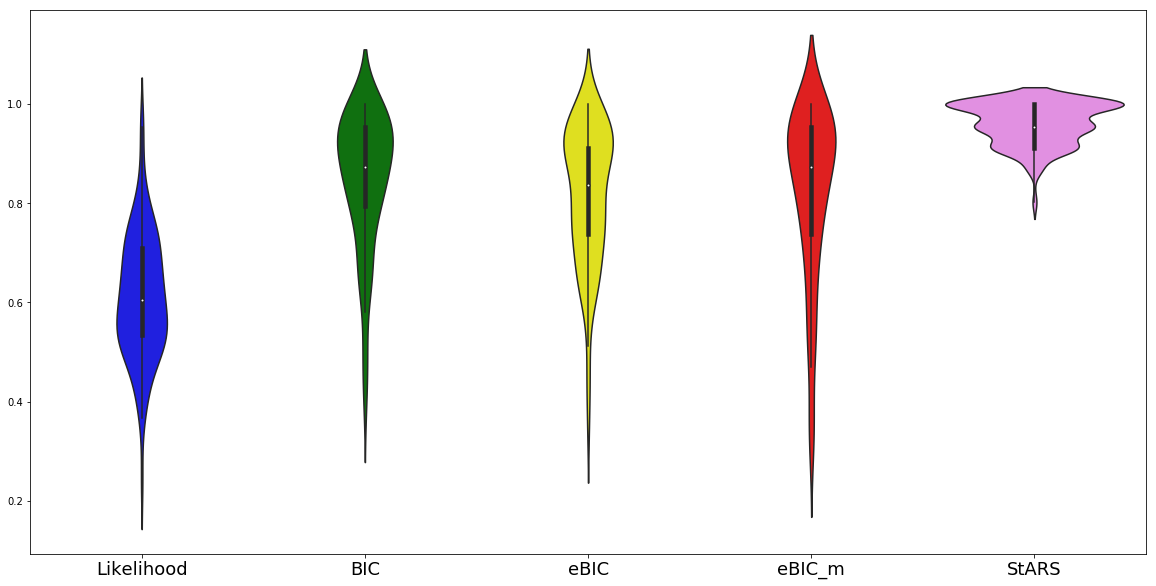

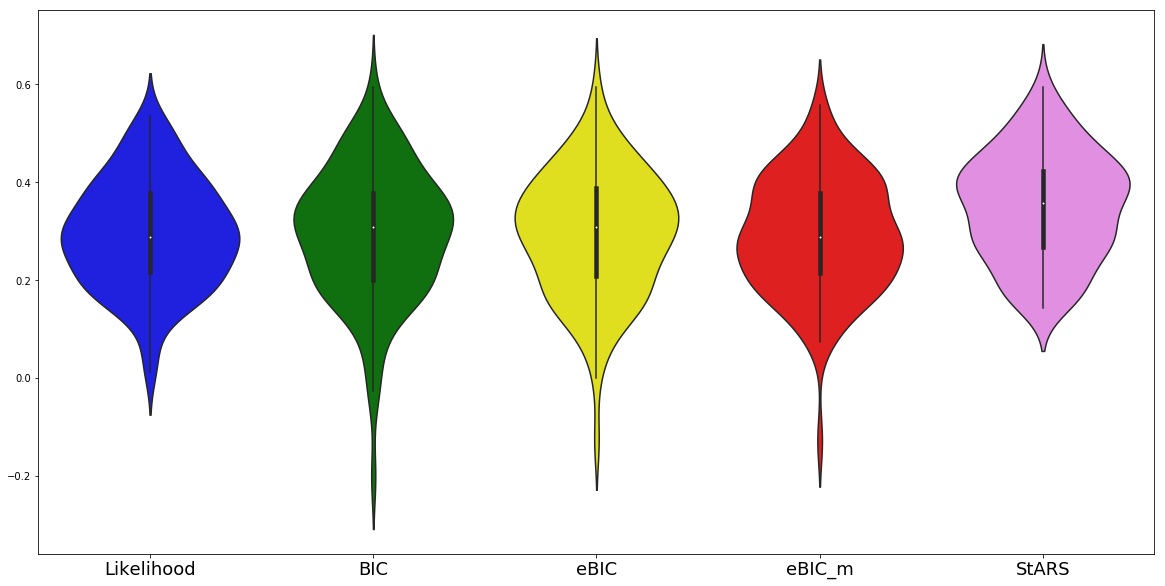

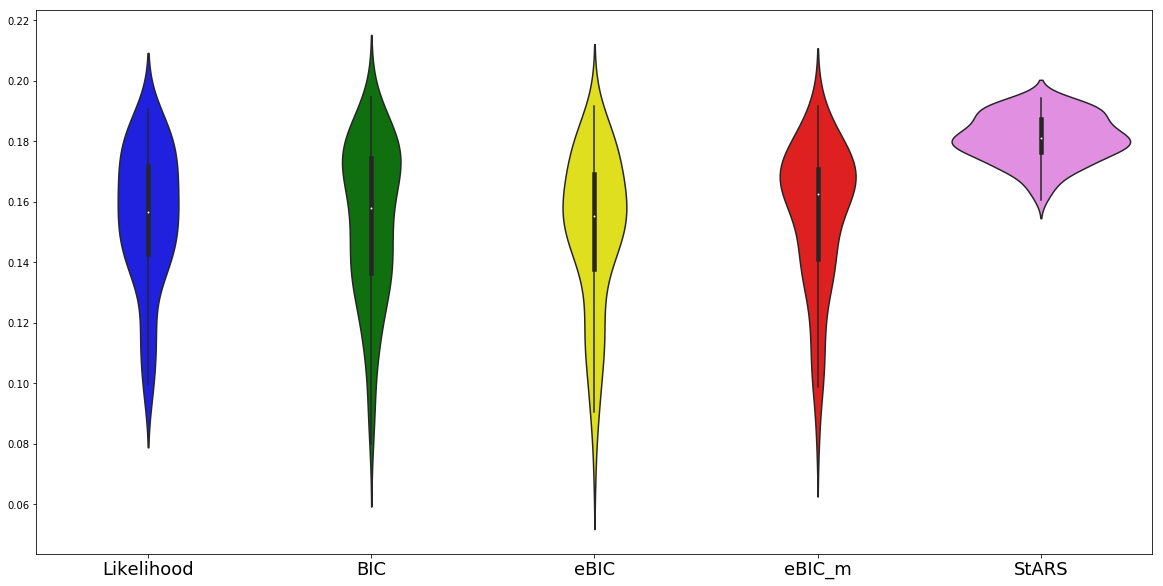

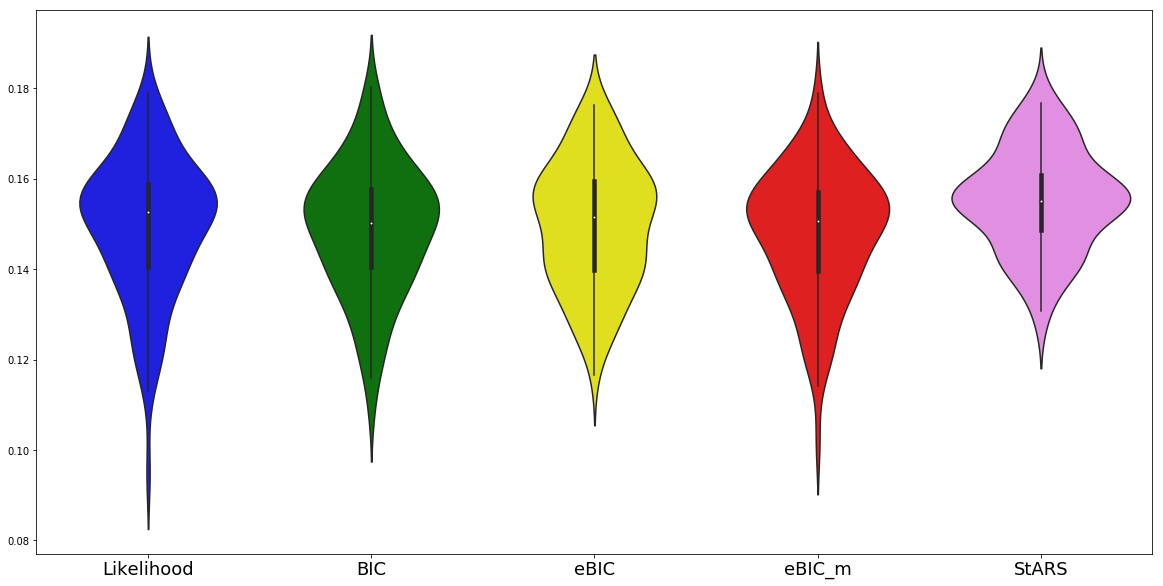

In [146]:
from matplotlib.patches import Patch
fig = plt.figure(figsize=(30,10))

means = []
for t in types:
    means.append(res_1000_10[0][t])
for t in types:
    means.append(res_100_10[0][t])
for t in types:
    means.append(res_100_100[0][t])
for t in types:
    means.append(res_20_100[0][t])
means = np.array(means)

types_dataset = ['1000s_10v', '100s_10v', '100s_100v', '10s_100v']
for i, j in zip([0,5,10,15], [0,1,2,3]):
    fig = plt.figure(figsize=(20,10))
    ax = sns.violinplot(data=means[i:i+5].T, palette=['blue', 'green', 'yellow', 'red', 'violet'])
    ax.set_xticklabels([])
    legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                             label='Likelihood'),
                       Patch(facecolor='green', edgecolor='green',
                             label='BIC'),
                       Patch(facecolor='yellow', edgecolor='yellow',
                             label='eBIC'),
                       Patch(facecolor='red', edgecolor='red',
                             label='eBIC_m'),
                       Patch(facecolor='violet', edgecolor='violet',
                             label='StARS'),
                       ]
    #ax.legend(handles=legend_elements, fontsize=18)
    ax.set_xticklabels(['Likelihood', 'BIC', 'eBIC', 'eBIC_m', 'StARS'], fontsize=18)
    plt.savefig('./results/MCC_train_'+types_dataset[j]+'.png', transparent=True, dpi=200)

<Figure size 2160x720 with 0 Axes>

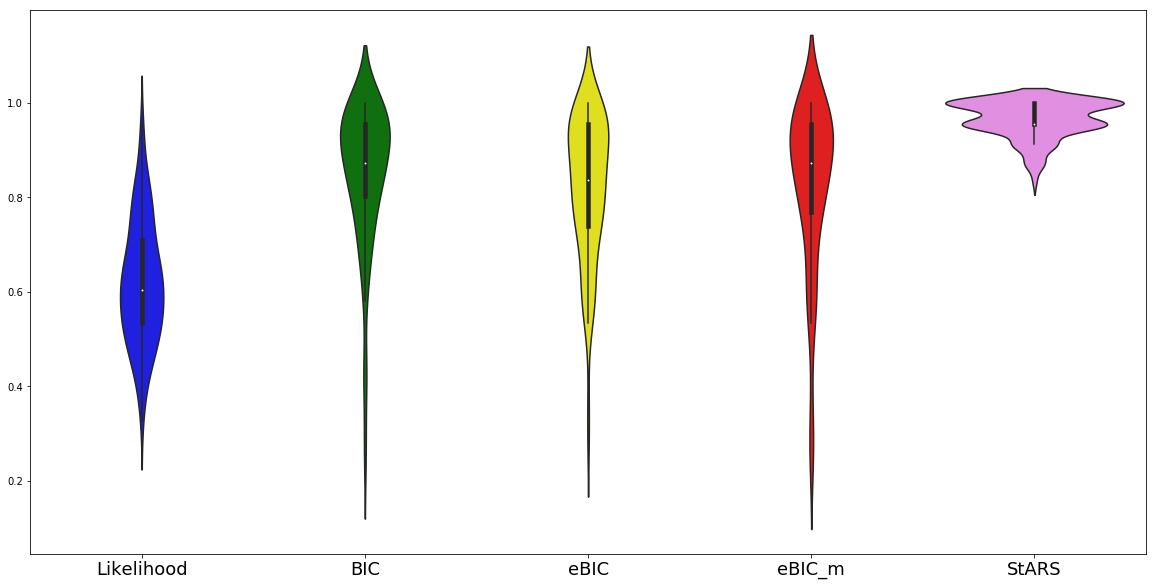

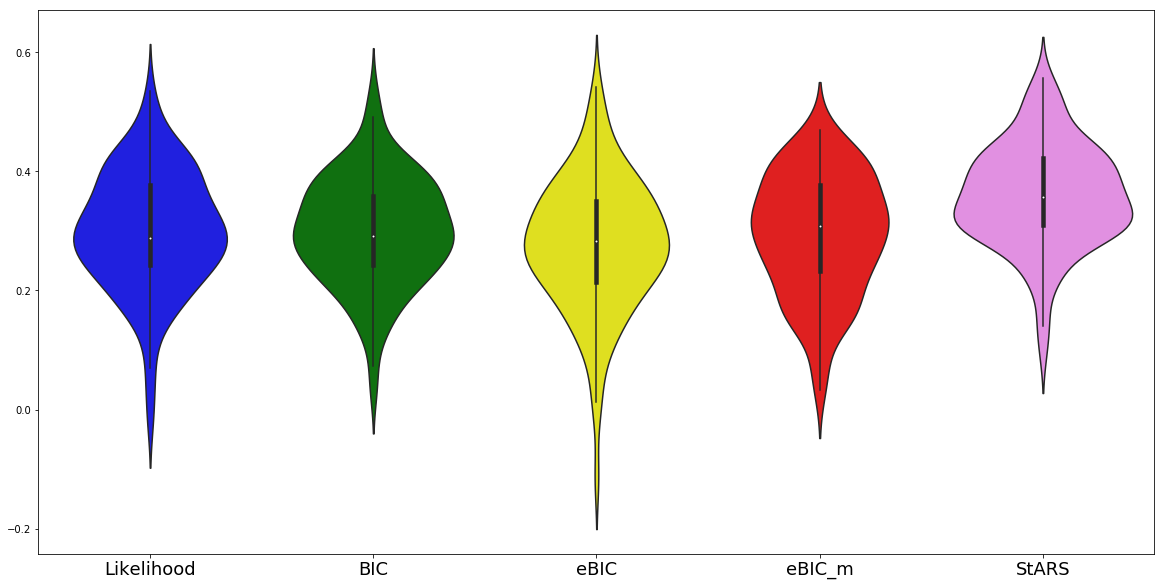

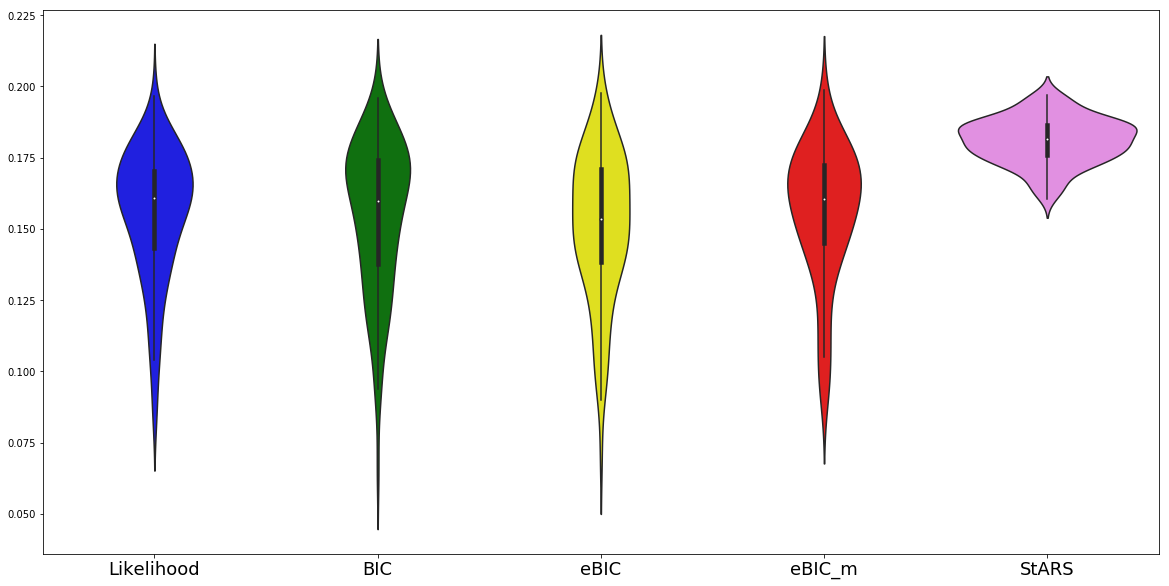

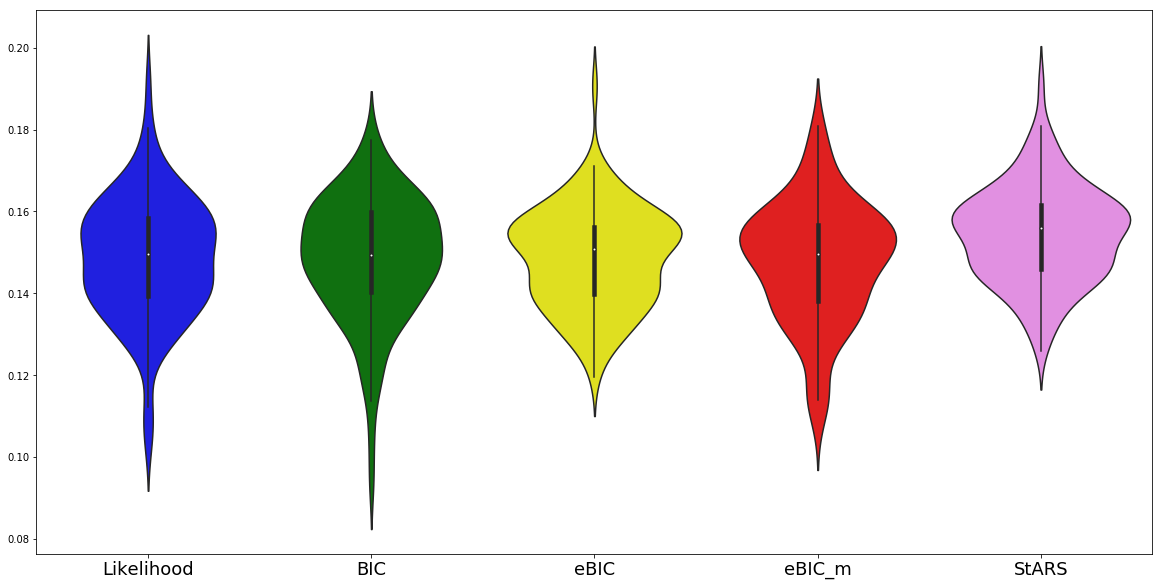

In [147]:
from matplotlib.patches import Patch
fig = plt.figure(figsize=(30,10))

means = []
for t in types:
    means.append(res_1000_10[1][t])
for t in types:
    means.append(res_100_10[1][t])
for t in types:
    means.append(res_100_100[1][t])
for t in types:
    means.append(res_20_100[1][t])
means = np.array(means)

types_dataset = ['1000s_10v', '100s_10v', '100s_100v', '10s_100v']
for i, j in zip([0,5,10,15], [0,1,2,3]):
    fig = plt.figure(figsize=(20,10))
    ax = sns.violinplot(data=means[i:i+5].T, palette=['blue', 'green', 'yellow', 'red', 'violet'])
    ax.set_xticklabels([])
    legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                             label='Likelihood'),
                       Patch(facecolor='green', edgecolor='green',
                             label='BIC'),
                       Patch(facecolor='yellow', edgecolor='yellow',
                             label='eBIC'),
                       Patch(facecolor='red', edgecolor='red',
                             label='eBIC_m'),
                       Patch(facecolor='violet', edgecolor='violet',
                             label='StARS'),
                       ]
    #ax.legend(handles=legend_elements, fontsize=18)
    ax.set_xticklabels(['Likelihood', 'BIC', 'eBIC', 'eBIC_m', 'StARS'], fontsize=18)
    plt.savefig('./results/MCC_test_'+types_dataset[j]+'.png', transparent=True, dpi=200)

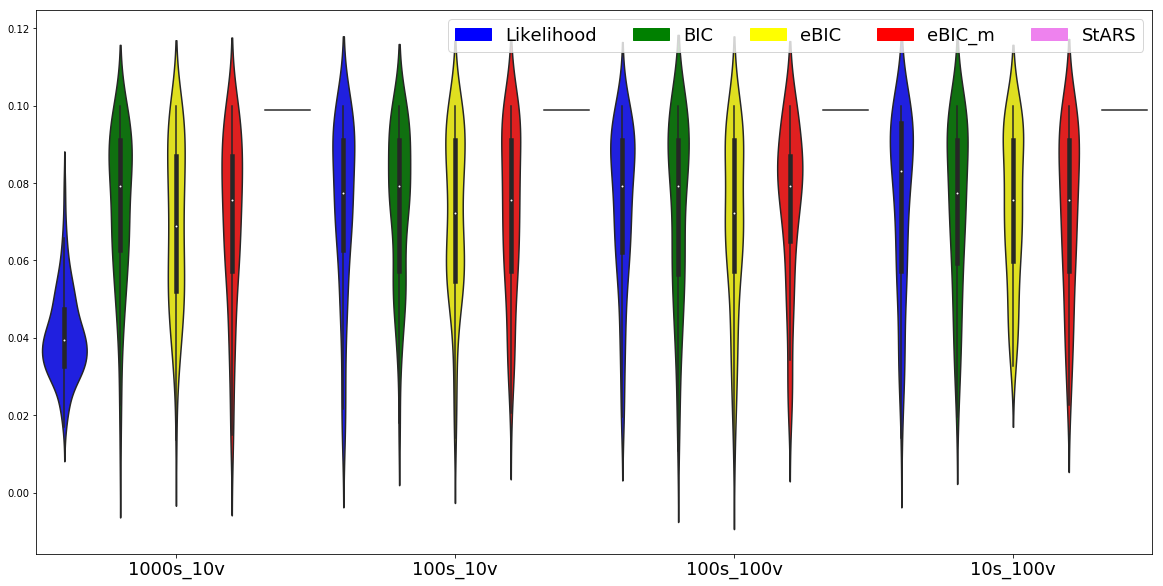

In [148]:
from matplotlib.patches import Patch


means = []
for t in types:
    means.append(res_1000_10[6][t])
for t in types:
    means.append(res_100_10[6][t])
for t in types:
    means.append(res_100_100[6][t])
for t in types:
    means.append(res_20_100[6][t])
means = np.array(means)

types_dataset = ['1000s_10v', '100s_10v', '100s_100v', '10s_100v']
fig = plt.figure(figsize=(20,10))
ax = sns.violinplot(data=means.T, palette=['blue', 'green', 'yellow', 'red', 'violet', 'blue', 'green', 'yellow', 'red', 'violet', 'blue', 'green', 'yellow', 'red', 'violet', 'blue', 'green', 'yellow', 'red', 'violet'])
ax.set_xticklabels([])
legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='Likelihood'),
                   Patch(facecolor='green', edgecolor='green',
                         label='BIC'),
                   Patch(facecolor='yellow', edgecolor='yellow',
                         label='eBIC'),
                   Patch(facecolor='red', edgecolor='red',
                         label='eBIC_m'),
                   Patch(facecolor='violet', edgecolor='violet',
                         label='StARS'),
                   ]
ax.legend(handles=legend_elements, ncol=5, fontsize=18)
ax.set_xticks([2,7,12,17])
ax.set_xticklabels(types_dataset, fontsize=18)
plt.savefig('./results/distribution_parameters_'+types_dataset[j]+'.png', transparent=True, dpi=200)

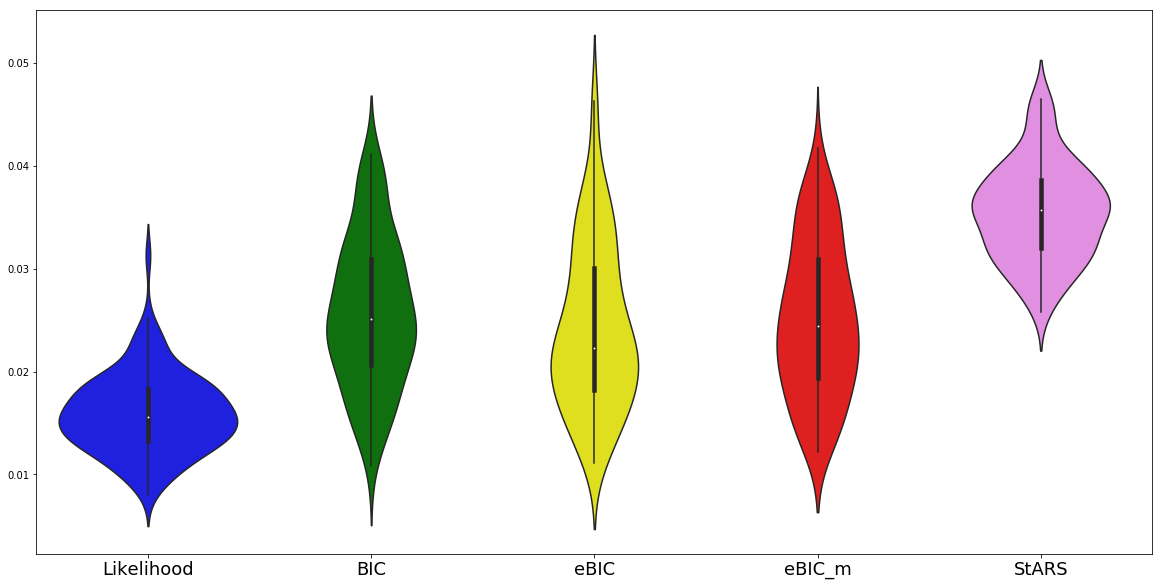

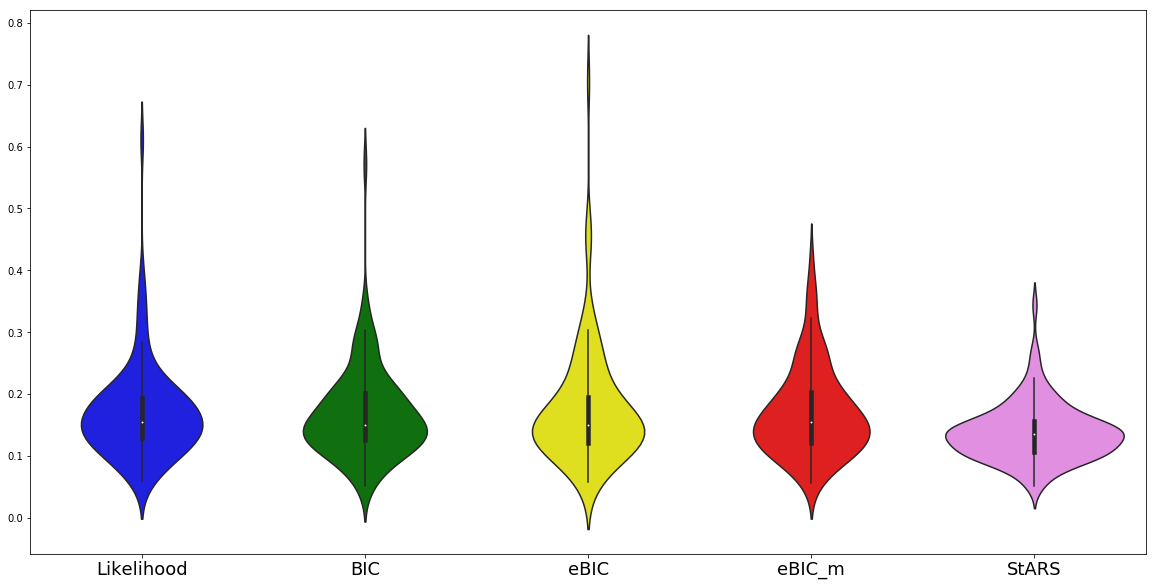

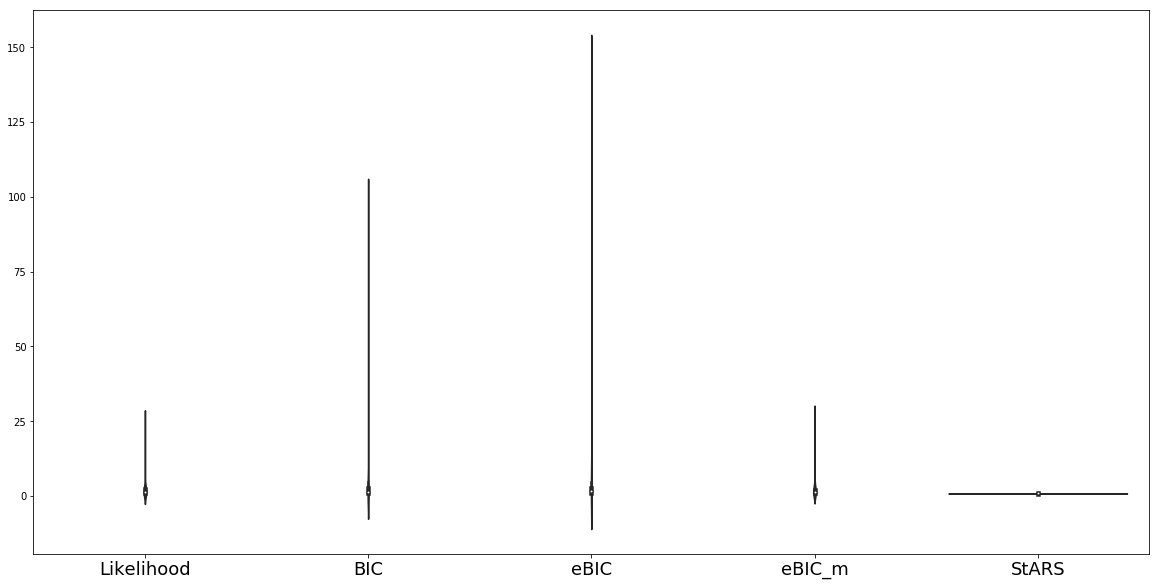

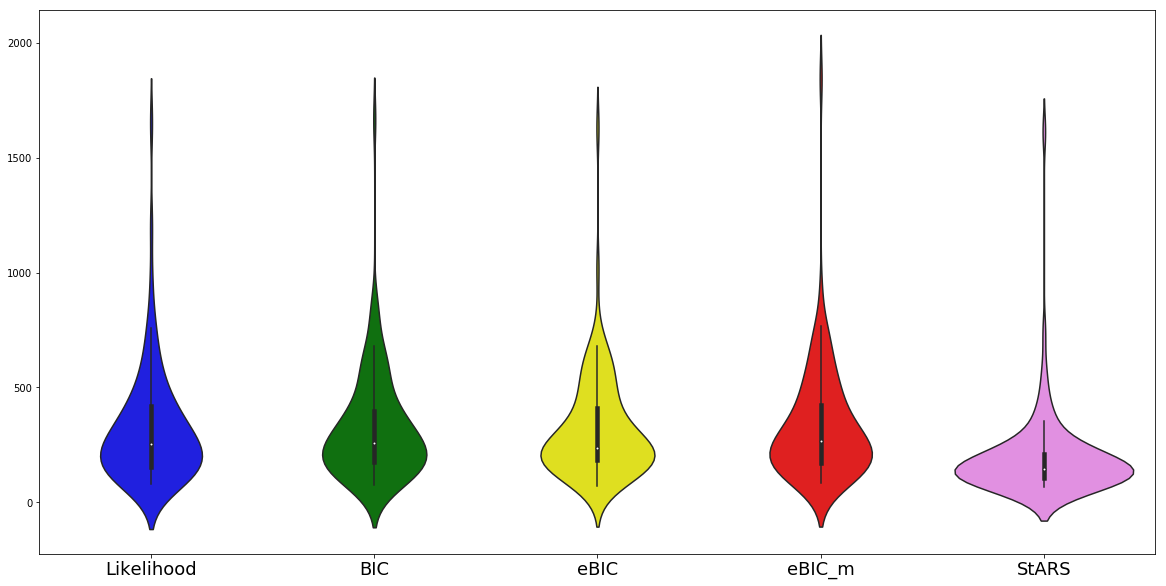

In [149]:
from matplotlib.patches import Patch

means = []
for t in types:
    means.append(res_1000_10[5][t])
for t in types:
    means.append(res_100_10[5][t])
for t in types:
    means.append(res_100_100[5][t])
for t in types:
    means.append(res_20_100[5][t])
means = np.array(means)

types_dataset = ['1000s_10v', '100s_10v', '100s_100v', '10s_100v']
for i, j in zip([0,5,10,15], [0,1,2,3]):
    fig = plt.figure(figsize=(20,10))
    ax = sns.violinplot(data=means[i:i+5].T, palette=['blue', 'green', 'yellow', 'red', 'violet'])
    ax.set_xticklabels([])
    legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                             label='Likelihood'),
                       Patch(facecolor='green', edgecolor='green',
                             label='BIC'),
                       Patch(facecolor='yellow', edgecolor='yellow',
                             label='eBIC'),
                       Patch(facecolor='red', edgecolor='red',
                             label='eBIC_m'),
                       Patch(facecolor='violet', edgecolor='violet',
                             label='StARS'),
                       ]
    #ax.legend(handles=legend_elements, fontsize=18)
    ax.set_xticklabels(['Likelihood', 'BIC', 'eBIC', 'eBIC_m', 'StARS'], fontsize=18)
    plt.savefig('./results/error_norm_test_'+types_dataset[j]+'.png', transparent=True, dpi=200)

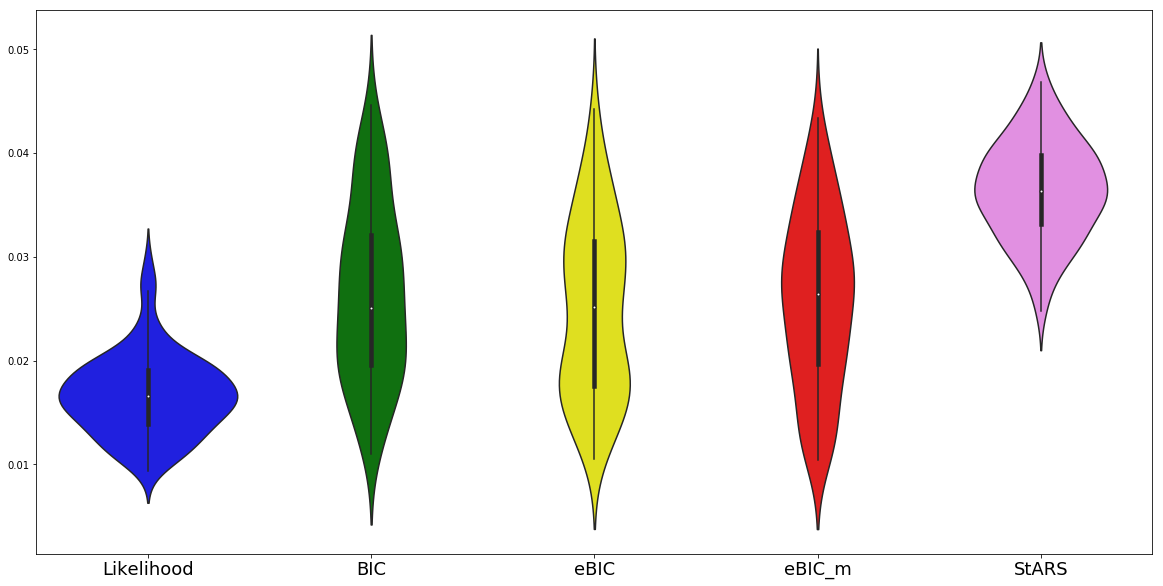

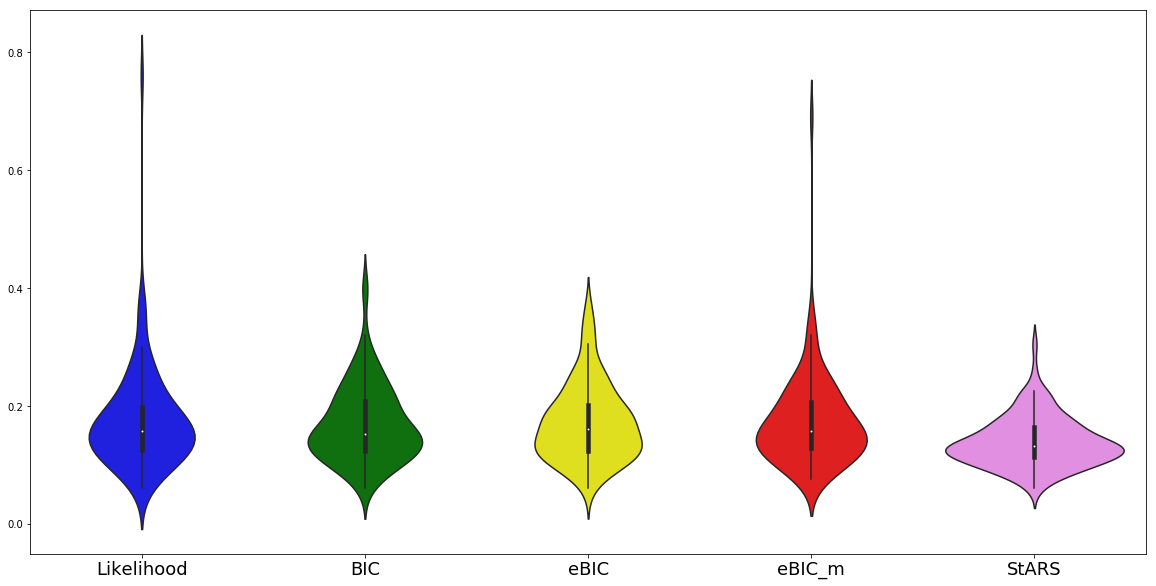

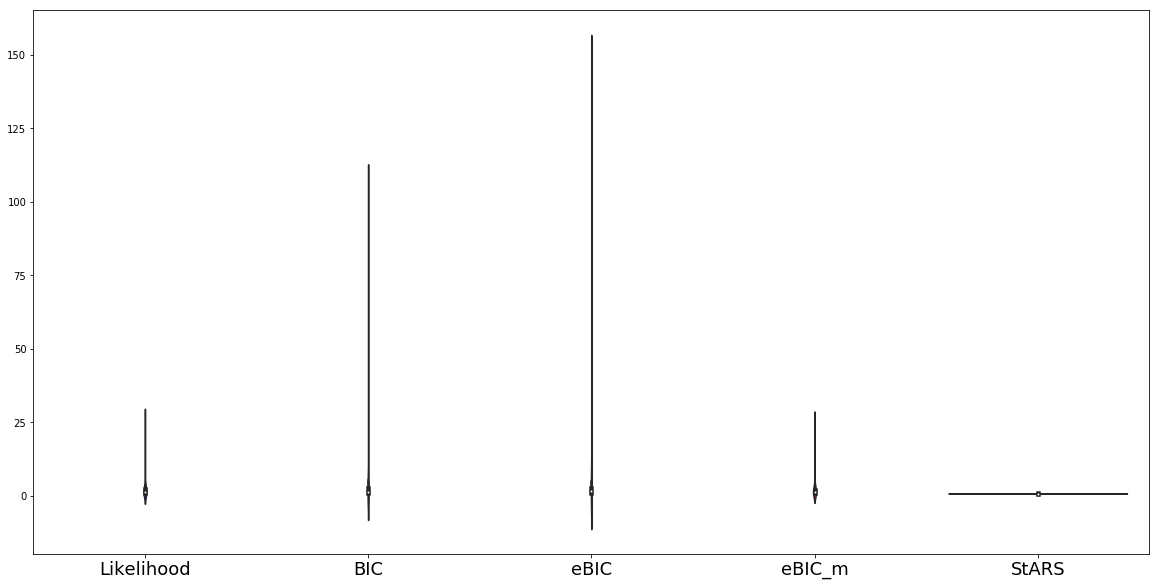

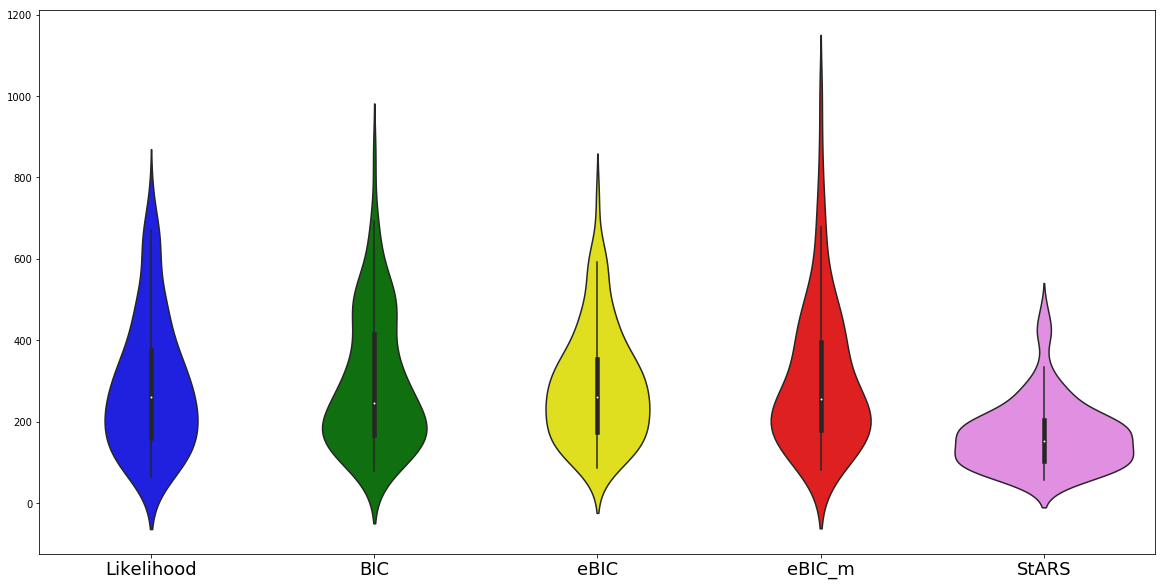

In [150]:
from matplotlib.patches import Patch

means = []
for t in types:
    means.append(res_1000_10[4][t])
for t in types:
    means.append(res_100_10[4][t])
for t in types:
    means.append(res_100_100[4][t])
for t in types:
    means.append(res_20_100[4][t])
means = np.array(means)

types_dataset = ['1000s_10v', '100s_10v', '100s_100v', '10s_100v']
for i, j in zip([0,5,10,15], [0,1,2,3]):
    fig = plt.figure(figsize=(20,10))
    ax = sns.violinplot(data=means[i:i+5].T, palette=['blue', 'green', 'yellow', 'red', 'violet'])
    ax.set_xticklabels([])
    legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                             label='Likelihood'),
                       Patch(facecolor='green', edgecolor='green',
                             label='BIC'),
                       Patch(facecolor='yellow', edgecolor='yellow',
                             label='eBIC'),
                       Patch(facecolor='red', edgecolor='red',
                             label='eBIC_m'),
                       Patch(facecolor='violet', edgecolor='violet',
                             label='StARS'),
                       ]
    #ax.legend(handles=legend_elements, fontsize=18)
    ax.set_xticklabels(['Likelihood', 'BIC', 'eBIC', 'eBIC_m', 'StARS'], fontsize=18)
    plt.savefig('./results/error_norm_train_'+types_dataset[j]+'.png', transparent=True, dpi=200)

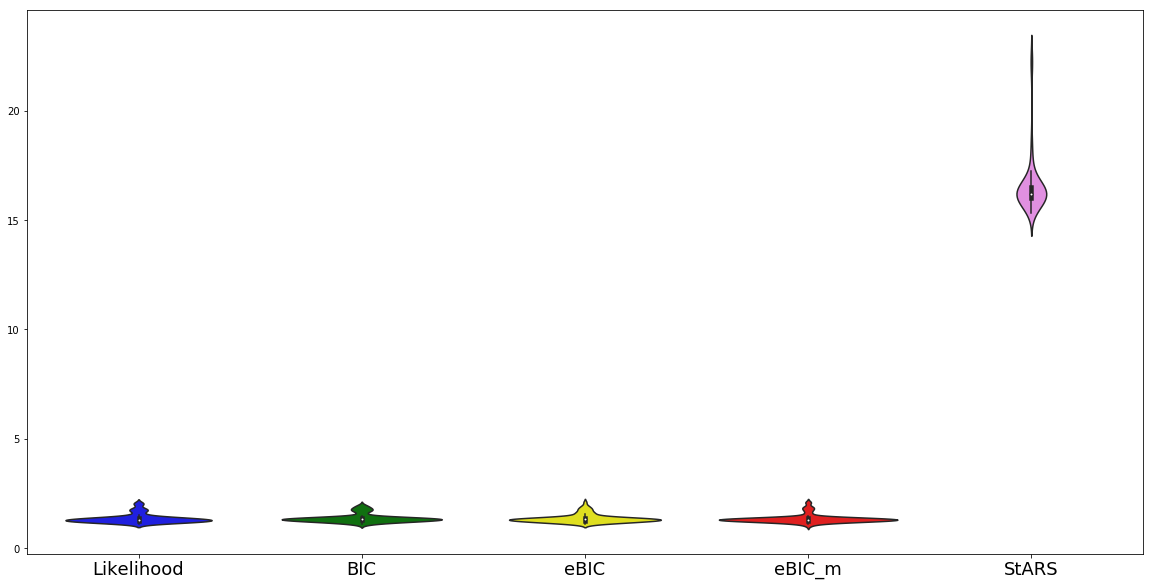

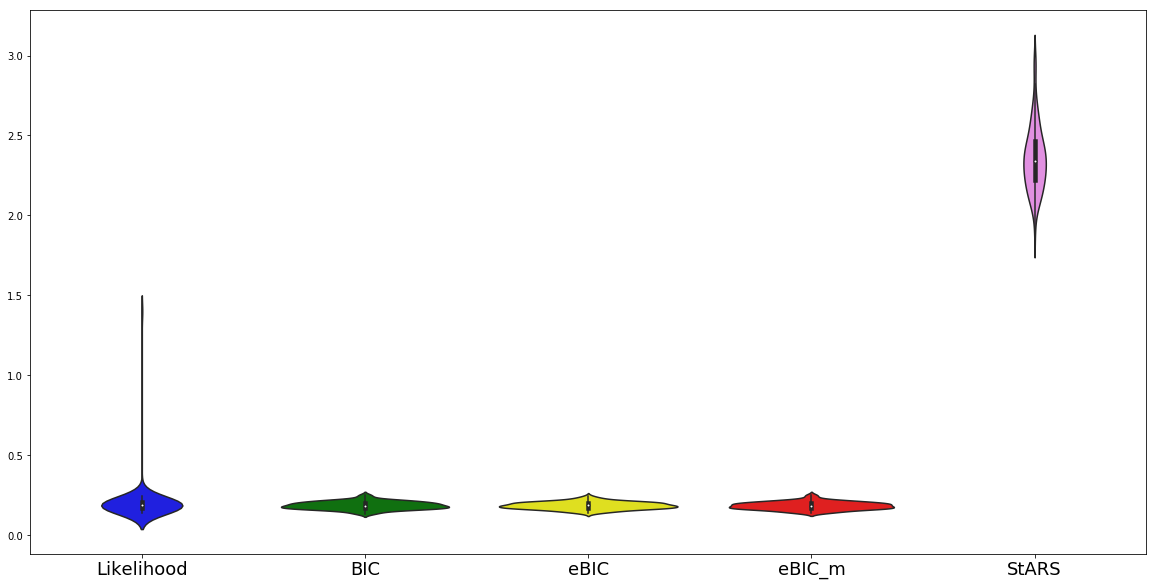

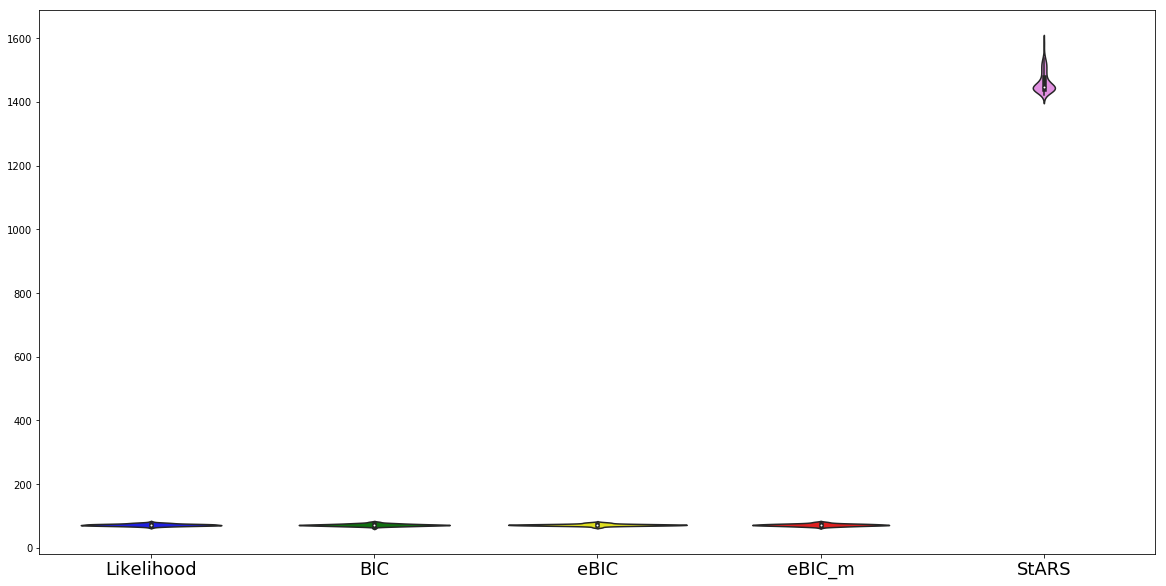

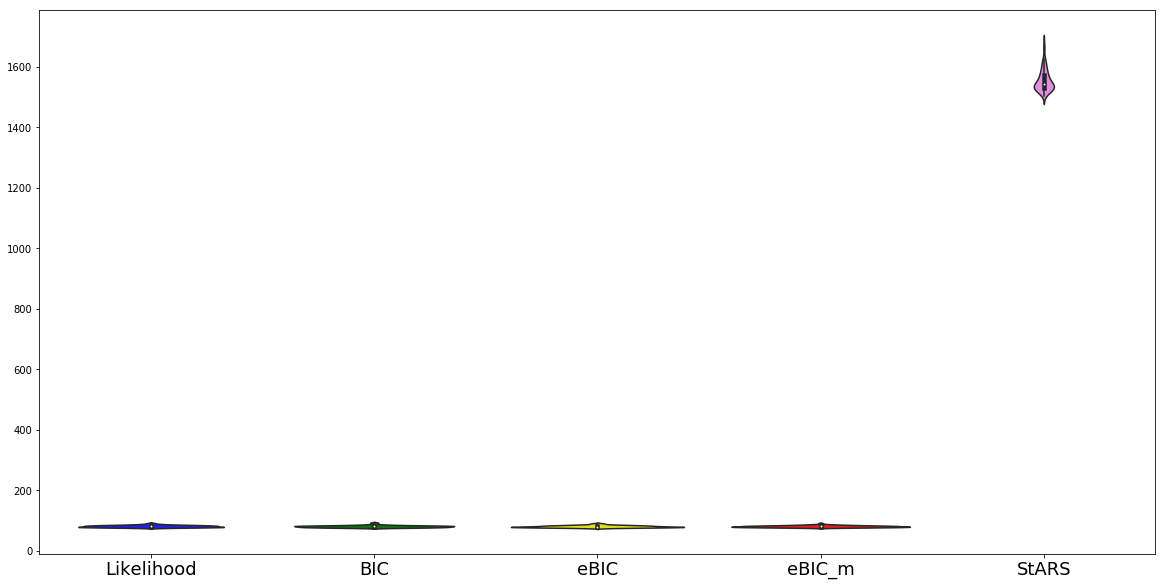

In [151]:
from matplotlib.patches import Patch

means = []
for t in types:
    means.append(res_1000_10[7][t])
for t in types:
    means.append(res_100_10[7][t])
for t in types:
    means.append(res_100_100[7][t])
for t in types:
    means.append(res_20_100[7][t])
means = np.array(means)

types_dataset = ['1000s_10v', '100s_10v', '100s_100v', '10s_100v']
for i, j in zip([0,5,10,15], [0,1,2,3]):
    fig = plt.figure(figsize=(20,10))
    ax = sns.violinplot(data=means[i:i+5].T, palette=['blue', 'green', 'yellow', 'red', 'violet'])
    ax.set_xticklabels([])
    legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                             label='Likelihood'),
                       Patch(facecolor='green', edgecolor='green',
                             label='BIC'),
                       Patch(facecolor='yellow', edgecolor='yellow',
                             label='eBIC'),
                       Patch(facecolor='red', edgecolor='red',
                             label='eBIC_m'),
                       Patch(facecolor='violet', edgecolor='violet',
                             label='StARS'),
                       ]
    #ax.legend(handles=legend_elements, fontsize=18)
    ax.set_xticklabels(['Likelihood', 'BIC', 'eBIC', 'eBIC_m', 'StARS'], fontsize=18)
    plt.savefig('./results/time_'+types_dataset[j]+'.png', transparent=True, dpi=200)

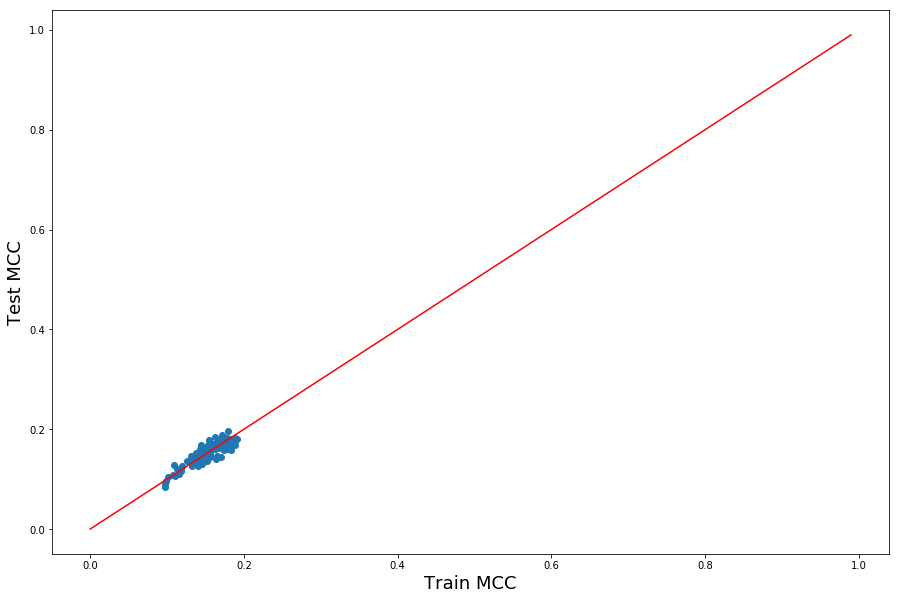

In [65]:
plt.figure(figsize=(15,10))
plt.scatter(res_100_100[0]['likelihood'], res_100_100[1]['likelihood'])
plt.xlabel('Train MCC', fontsize=18)
plt.ylabel('Test MCC', fontsize=18)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color='red')
#plt.title('Correlation Train-Test Likelihood score', fontsize=18)
#plt.savefig("results/likelihood_MCC_train_test.pdf", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(train_scores_likelihood, hist=True, kde=True, 
             bins=int(20), color = 'darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Train')
#plt.hist(, bins=20, color='red', alpha=0.5)
sns.distplot(test_scores_likelihood, hist=True, kde=True, 
             bins=int(20), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Test')
plt.xlabel('MCC score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.legend(fontsize=18)
plt.title('MCC empirical distribution', fontsize=18)
plt.savefig("results/likelihood_distribution_MCC_train_test_distr.pdf", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train_scores_likelihood_n, test_scores_likelihood_n)
plt.xlabel('Train precision matrix norm', fontsize=18)
plt.ylabel('Test precision matrix norm', fontsize=18)
#plt.plot(np.arange(0, 0.04, 0.01), np.arange(0, 0.04, 0.01), color='red')
plt.title('Correlation Train-Test Likelihood norm', fontsize=18)
plt.savefig("results/likelihood_norm_train_test.png", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train_likelihood, test_likelihood)
plt.xlabel('Train likelihood score', fontsize=18)
plt.ylabel('Test likelihood score', fontsize=18)
#plt.plot(np.arange(0, 0.04, 0.01), np.arange(0, 0.04, 0.01), color='red')
plt.title('Correlation Train-Test Likelihood', fontsize=18)
plt.savefig("results/likelihood_train_test.png", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train_likelihood, test2_likelihood)
plt.xlabel('Train likelihood score', fontsize=18)
plt.ylabel('Test likelihood score', fontsize=18)
#plt.plot(np.arange(0, 0.04, 0.01), np.arange(0, 0.04, 0.01), color='red')
plt.title('Correlation Train-Test Likelihood', fontsize=18)
plt.savefig("results/likelihood2_train_test.png", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(np.arange(0, len(alphas_likelihood)), alphas_likelihood)
mean = np.mean(alphas_likelihood)
std = np.std(alphas_likelihood)
plt.axhline(mean, c='red')
plt.xlabel('Repetition of the experiment', fontsize=18)
plt.ylabel(r'Value of regularization parameter $\lambda$', fontsize=18)
plt.title('Selection of the regularization parameter', fontsize=18)
plt.fill_between(np.arange(-2, len(alphas_likelihood)+2), mean-std, y2=mean+std, color='red', alpha=0.5)
plt.savefig("results/likelihood_alpha_distribution1.pdf", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
import seaborn as sns 
plt.figure(figsize=(15,10))

sns.distplot(alphas_likelihood, hist=True, kde=True, 
             bins=int(20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title(r'Empirical distribution of $\lambda$ values', fontsize=18)
plt.savefig("results/likelihood_alpha_distribution2.pdf", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
from importlib import reload
import regain.scores; reload(regain.scores)
from regain.scores import EBIC_m

In [ ]:
ss = partial(score, score_type='ebic_m')

est = GraphicalLasso()
rscv = RandomizedSearchCV(est, refit=True, param_distributions={'alpha':np.logspace(-3, -1, 100)}, cv=5, scoring=ss)

sss = ShuffleSplit(n_splits=1000, test_size=0.5)
train_scores_bic = []
test_scores_bic= []
train_bic = []
test_bic = []
alphas_bic = []
test2_bic = []
train_scores_bic_n = []
test_scores_bic_n = []
theta_raveled = (theta[~np.eye(theta.shape[0],dtype=bool)].ravel()!=0).astype(int)
for train, test in sss.split(X):
    rscv.fit(X[train,:])
    alphas_bic.append(rscv.best_estimator_.alpha)
    precision_raveled = (rscv.best_estimator_.precision_[~np.eye(theta.shape[0],dtype=bool)].ravel()!=0).astype(int)
    train_scores_bic.append(matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0))
    train_scores_bic_n.append(error_norm(theta, rscv.best_estimator_.precision_))
    train_bic.append(ss(rscv.best_estimator_, X[train, :]))
    test_bic.append(ss(rscv.best_estimator_, X[test, :]))
    rscv.best_estimator_.fit(X[test,:])
    
    test_scores_bic.append((matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0)))
    test_scores_bic_n.append(error_norm(theta, rscv.best_estimator_.precision_))
    test2_bic.append(ss(rscv.best_estimator_, X[test, :]))

In [ ]:
name = 'eBIC_m'

plt.figure(figsize=(15,10))
plt.scatter(train_scores_bic, test_scores_bic)
plt.xlabel('Train '+name+' score', fontsize=18)
plt.ylabel('Test '+name+' score', fontsize=18)
#plt.plot(np.arange(0, 0.04, 0.01), np.arange(0, 0.04, 0.01), color='red')
plt.title('MCC Train-Test '+name, fontsize=18)
plt.savefig("results/"+name+"C_train_test.png", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(train_scores_bic, hist=True, kde=True, 
             bins=int(20), color = 'darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Train')
#plt.hist(, bins=20, color='red', alpha=0.5)
sns.distplot(test_scores_bic, hist=True, kde=True, 
             bins=int(20), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Test')
plt.xlabel('MCC score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.legend(fontsize=18)
plt.title('MCC empirical distribution', fontsize=18)
plt.savefig("results/"+name+"_distribution_MCC_train_test_distr.pdf", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train_scores_bic_n, test_scores_bic_n)
plt.xlabel('Train '+name+' score', fontsize=18)
plt.ylabel('Test '+name+' score', fontsize=18)
#plt.plot(np.arange(0, 0.04, 0.01), np.arange(0, 0.04, 0.01), color='red')
plt.title('Norm error Train-Test '+name, fontsize=18)
plt.savefig("results/"+name+"norm_train_test.pdf", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train_bic, test_bic)
plt.xlabel('Train '+name+' score', fontsize=18)
plt.ylabel('Test '+name+' score', fontsize=18)
#plt.plot(np.arange(0, 0.04, 0.01), np.arange(0, 0.04, 0.01), color='red')
plt.title('CorrelationTrain-Test '+name, fontsize=18)
plt.savefig("results/"+name+"correlation_train_test.pdf", transparent=True, bbox_inches='tight', dpi=200)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(np.arange(0, len(alphas_bic)), alphas_bic)
mean = np.mean(alphas_bic)
std = np.std(alphas_bic)
plt.axhline(mean, c='red')
plt.fill_between(np.arange(-2, len(alphas_bic)+2), mean-std, y2=mean+std, color='red', alpha=0.5)
plt.xlabel('Repetition of the experiment', fontsize=18)
plt.ylabel(r'Value of regularization parameter $\lambda$', fontsize=18)
plt.title('Selection of the regularization parameter', fontsize=18)
plt.savefig("results/"+name+"_alpha_distribution1.png", transparent=True, bbox_inches='tight', dpi=200)



In [ ]:
import seaborn as sns 
plt.figure(figsize=(15,10))

sns.distplot(alphas_bic, hist=True, kde=True, 
             bins=int(20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title(r'Empirical distribution of $\lambda$ values', fontsize=18)
plt.savefig("results/"+name+"_alpha_distribution2.pdf", transparent=True, bbox_inches='tight', dpi=200)